# Train multi-layer convolutional neural network

# Multi-Layered CNNs
### In the previous unit we have learned about convolutional filters that can extract patterns from images. For our MNIST classifier we used 9 5x5 filters, resulting in 9x24x24 tensor.

### We can use the same idea of convolution to extract higher-level patterns in the image. For example, rounded edges of digits such as 8 and 9 can be composed from a number of smaller strokes. To recognize those patterns, we can build another layer of convolution filters on top of the result of the first layer.

In [1]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2022-06-23 12:33:04--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py.4’

pytorchcv.py.4      100%[===================>]   6.22K  --.-KB/s    in 0s      

2022-06-23 12:33:05 (14.2 MB/s) - ‘pytorchcv.py.4’ saved [6371/6371]



In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

# Pooling layers
### First convolutional layers looks for primitive patterns, such as horizontal or vertical lines. Next level of convolutional layers on top of them look for higher-level patterns, such as primitive shapes. More convolutional layers can combine those shapes into some parts of the picture, up to the final object that we are trying to classify. This creates a hierarchy of extracted patterns.

### When doing so, we also need to apply one trick: reducing the spatial size of the image. Once we have detected there is a horizontal stoke within a sliding window, it is not so important at which exact pixel it occurred. Thus we can "scale down" the size of the image, which is done using one of the pooling layers:

### Average Pooling takes a sliding window (for example, 2x2 pixels) and computes an average of values within the window
### Max Pooling replaces the window with the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window.

### Thus, in a typical CNN there would be composed of several convolutional layers, with pooling layers in between them to decrease dimensions of the image. We would also increase the number of filters, because as patterns become more advanced - there are more possible interesting combinations that we need to be looking for.



### Because of decreasing spatial dimensions and increasing feature/filters dimensions, this architecture is also called pyramid architecture.

### In the next example, we will use two-layered CNN:

In [3]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            --                        --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

## Note a few things about the definition:

### Instead of using Flatten layer, we are flattening the tensor inside forward function using view function, which is similar to reshape function in numpy. Since flattening layer does not have trainable weights, it is not required that we create a separate layer instance within our class - we can just use a function from torch.nn.functional namespace.
### We use just one instance of pooling layer in our model, also because it does not contain any trainable parameters, and thus one instance can be effectively reused.
### The number of trainable parameters (~8.5K) is dramatically smaller than in previous cases (80K in Perceptron, 50K in one-layer CNN). This happens because convolutional layers in general have few parameters, independent of the input image size. Also, due to pooling, dimensionality of the image is significantly reduced before applying final dense layer. Small number of parameters have positive impact on our models, because it helps to prevent overfitting even on smaller dataset sizes.

In [4]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.951, Val acc=0.979, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.981, Val acc=0.984, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=0.985, Val acc=0.985, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.986, Val acc=0.983, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=0.988, Val acc=0.985, Train loss=0.000, Val loss=0.000


### What you should probably observe is that we are able to achieve higher accuracy, and much faster - just with 1 or 2 epochs. It means that sophisticated network architecture needs much fewer data to figure out what is going on, and to extract generic patterns from our images.



## Playing with real images from the CIFAR-10 dataset
### While our handwritten digit recognition problem may seem like a toy problem, we are now ready to do something more serious. Let's explore more advanced dataset of pictures of different objects, called CIFAR-10. It contains 60k 32x32 color images, divided into 10 classes.



In [5]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


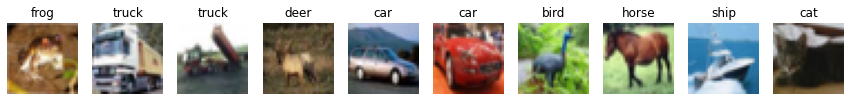

In [6]:
display_dataset(trainset,classes=classes)

### A well-known architecture for CIFAR-10 is called LeNet, and has been proposed by Yann LeCun. It follows the same principles as we have outlined above. However, since all images are color, input tensor size is 3 * 32 * 32, and the 5 * 5 convolutional filter is applied across color dimension as well - meaning that the size of convolution kernel matrix is 3 * 5 * 5.
### We also do one more simplification to this model - we do not use log_softmax as output activation function, and just return the output of last fully-connected layer. In this case we can just use CrossEntropyLoss loss function to optimize the model.

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    --                        --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

### Training this network properly will take significant amount of time, and should preferably be done on GPU-enabled compute.
### In order to achieve better training results, we may need to experiment with some training parameters, such as learning rate. Thus, we explicitly define a stochastic gradient descent (SGD) optimizer here, and pass training parameters. You can adjust those parameters and observe how they affect training.

In [8]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.261, Val acc=0.380, Train loss=0.143, Val loss=0.120
Epoch  1, Train acc=0.428, Val acc=0.473, Train loss=0.112, Val loss=0.104
Epoch  2, Train acc=0.505, Val acc=0.535, Train loss=0.098, Val loss=0.093


### The accuracy that we have been able to achieve with 3 epochs of training does not seem great. However, remember that blind guessing would only give us 10% accuracy, and that our problem is actually significantly more difficult than MNIST digit classification. Getting above 50% accuracy in such a short training time seems like a good accomplishment.



# Pre-trained models and transfer learning
### Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

### This approach is called transfer learning, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as ImageNet. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [9]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2022-06-23 12:35:49--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py.5’

pytorchcv.py.5      100%[===================>]   6.22K  --.-KB/s    in 0.001s  

2022-06-23 12:35:51 (4.42 MB/s) - ‘pytorchcv.py.5’ saved [6371/6371]



In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

# Cats vs. Dogs Dataset
### In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use Kaggle Cats vs. Dogs Dataset, which can also be downloaded from Microsoft.

### Let's download this dataset and extract it into data directory (this process may take some time!):

In [13]:
if not os.path.exists('data/kagglecatsanddogs_3367a.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [16]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

### Unfortunately, there are some corrupt image files in the dataset. We need to do quick cleaning to check for corrupted files. In order not to clobber this tutorial, we moved the code to verify dataset into a module, and we will just call it here. check_image_dir goes over the whole dataset image by image, tries to load the image and check if it can be loaded correctly. All corrupt images are deleted.

In [17]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image: data/PetImages/Cat/666.jpg


/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupt image: data/PetImages/Dog/11702.jpg


### Next, let's load the images into PyTorch dataset, converting them to tensors and doing some normalization. We define image transformation pipeline by composing several primitive transformations using Compose:

### Resize resizes our image to 256x256 dimensions
### CenterCrop gets the central part of the image with size 224x224. Pre-trained VGG network has been trained on 224x224 images, thus we need to bring our dataset to this size.
### ToTensor normalizes pixel intensities to be in 0..1 range, and convert images to PyTorch tensors
### std_normalize transform is additional normalization step specific for VGG network. When training a VGG network, original images from ImageNet were transformed by subtracting dataset mean intensity by color and dividing by standard deviation (also by color). Thus, we need to apply the same transformation to our dataset, so that all images are processed correctly.
### There are a few reason why we resized images to size 256, and then cropped to 224 pixels:

### We wanted to demonstrate more possible transformations.
### Pets are usually somewhere in the central part of the image, so we can improve classification by focusing more on the central part
### Since some of the images are not square, we end up having padded parts of the image that do not contain any useful picture data, and cropping the image a bit reduces the padded part.

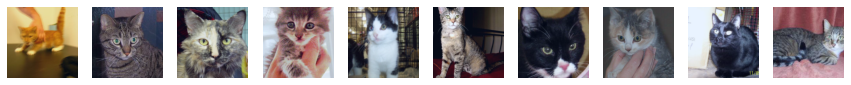

In [2]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset)

# Pre-trained models
### There are many different pre-trained models available inside torchvision module, and even more models can be found on the Internet. Let's see how simplest VGG-16 model can be loaded and used:

In [ ]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

### The result that we have received is a number of an ImageNet class, which can be looked up here. We can use the following code to automatically load this class table and return the result:



In [ ]:
import json, requests
class_map = json.loads(requests.get("https://mslearntensorflowlp.blob.core.windows.net/metadata/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

### Let's also see the architecture of the VGG-16 network:



In [ ]:
summary(vgg,input_size=(1,3,224,224))

### In addition to the layer we already know, there is also another layer type called Dropout. These layers act as regularization technique. Regularization makes slight modifications to the learning algorithm so the model generalizes better. During training, dropout layers discard some proportion (around 30%) of the neurons in the previous layer, and training happens without them. This helps to get the optimization process out of local minima, and to distribute decisive power between different neural paths, which improves overall stability of the network.

# GPU computations
### Deep neural networks, such as VGG-16 and other more modern architectures require quite a lot of computational power to run. It makes sense to use GPU acceleration, if it is available. In order to do so, we need to explicitly move all tensors involved in the computation to GPU.

### The way it is normally done is to check the availability of GPU in the code, and define device variable that points to the computational device - either GPU or CPU.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

# Extracting VGG features
### If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using vgg.features method:

In [ ]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

### The dimension of feature tensor is 512x7x7, but in order to visualize it we had to reshape it to 2D form.

### Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called feature_tensor, and also labels into label_tensor:

In [ ]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break


### Now we can define vgg_dataset that takes data from this tensor, split it into training and test sets using random_split function, and train a small one-layer dense classifier network on top of extracted features:

In [ ]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

### The result is great, we can distinguish between a cat and a dog with almost 98% probability! However, we have only tested this approach on a small subset of all images, because manual feature extraction seems to take a lot of time.



# Transfer learning using one VGG network
### We can also avoid manually pre-computing the features by using the original VGG-16 network as a whole during training. Let's look at the VGG-16 object structure:

In [ ]:
print(vgg)

## You can see that the network contains:

### feature extractor (features), comprised of a number of convolutional and pooling layers
### average pooling layer (avgpool)
### final classifier, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)
### To train the end-to-end model that will classify our dataset, we need to:

### replace the final classifier with the one that will produce required number of classes. In our case, we can use one Linear layer with 25088 inputs and 2 output neurons.
### freeze weights of convolutional feature extractor, so that they are not trained. It is recommended to initially do this freezing, because otherwise untrained classifier layer can destroy the original pre-trained weights of convolutional extractor. Freezing weights can be accomplished by setting requires_grad property of all parameters to False

In [ ]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

### As you can see from the summary, this model contain around 15 million total parameters, but only 50k of them are trainable - those are the weights of classification layer. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

### Now let's train the model using our original dataset. This process will take a long time, so we will use the train_long function that will print some intermediate results without waiting for the end of epoch. It is highly recommended to run this training on GPU-enabled compute!

In [ ]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

### It looks like we have obtained reasonably accurate cats vs. dogs classifier! Let's save it for future use!



In [ ]:
torch.save(vgg,'data/cats_dogs.pth')

### We can then load the model from file at any time. You may find it useful in case the next experiment destroys the model - you would not have to re-start from scratch.

In [ ]:
vgg = torch.load('data/cats_dogs.pth')

# Fine-tuning transfer learning
### In the previous section, we have trained the final classifier layer to classify images in our own dataset. However, we did not re-train the feature extractor, and our model relied on the features that the model has learned on ImageNet data. If your objects visually differ from ordinary ImageNet images, this combination of features might not work best. Thus it makes sense to start training convolutional layers as well.

### To do that, we can unfreeze the convolutional filter parameters that we have previously frozen.

### Note: It is important that you freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If you immediately start training end-to-end network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.

In [ ]:
for x in vgg.features.parameters():
    x.requires_grad = True

### After unfreezing, we can do a few more epochs of training. You can also select lower learning rate, in order to minimize the impact on the pre-trained weights. However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching slightly higher level than in the case of fixed weights.

### Note: This training happens much slower, because we need to propagate gradients back through many layers of the network! You may want to watch the first few minibatches to see the tendency, and then stop the computation.

In [ ]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

# Other computer vision models
### VGG-16 is one of the simplest computer vision architectures. torchvision package provides many more pre-trained networks. The most frequently used ones among those are ResNet architectures, developed by Microsoft, and Inception by Google. For example, let's explore the architecture of the simplest ResNet-18 model (ResNet is a family of models with different depth, you can try experimenting with ResNet-151 if you want to see what a really deep model looks like):

In [ ]:
resnet = torchvision.models.resnet18()
print(resnet)

### As you can see, the model contains the same building blocks: feature extractor and final classifier (fc). This allows us to use this model in exactly the same manner as we have been using VGG-16 for transfer learning. You can try experimenting with the code above, using different ResNet models as the base model, and see how accuracy changes.



# Batch Normalization
### This network contains yet another type of layer: Batch Normalization. The idea of batch normalization is to bring values that flow through the neural network to right interval. Usually neural networks work best when all values are in the range of -1,1 or 0,1, and that is the reason that we scale/normalize our input data accordingly. However, during training of a deep network, it can happen that values get significantly out of this range, which makes training problematic. Batch normalization layer computes average and standard deviation for all values of the current minibatch, and uses them to normalize the signal before passing it through a neural network layer. This significantly improves the stability of deep networks.